In [1]:
import torch
import torchvision

dataset = {
    'train': torchvision.datasets.EMNIST('./data', split='letters', train=True,  download=True, transform=torchvision.transforms.ToTensor()),
    'test': torchvision.datasets.EMNIST('./data',  split='letters', train=False, download=True, transform=torchvision.transforms.ToTensor())
}

len(dataset['train']), len(dataset['test'])

(124800, 20800)

In [2]:
dataset['train'].class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

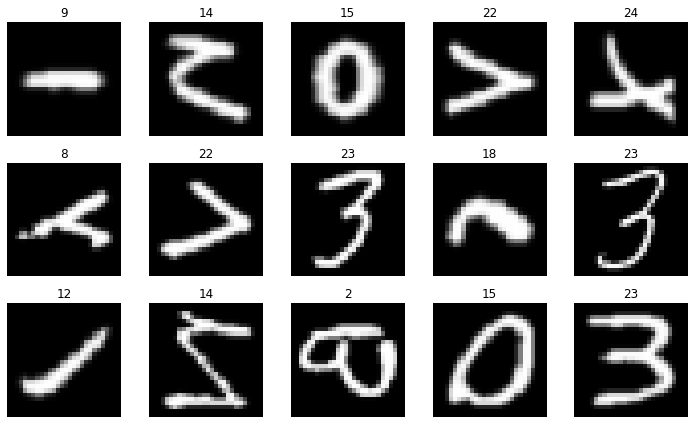

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        img, label = dataset['train'][ix]
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.axis("off")
        plt.title(label)
plt.tight_layout()
plt.show()

In [4]:
img.shape, img.dtype, img.max(), img.min()

(torch.Size([1, 28, 28]), torch.float32, tensor(1.), tensor(0.))

In [5]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=27):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*7*7, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [6]:
model = CNN()
output = model(torch.randn(64, 1, 28, 28))
output.shape

torch.Size([64, 27])

In [7]:
from tqdm import tqdm
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [8]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False, pin_memory=True)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 1, 28, 28])

In [9]:
model = CNN()
fit(model, dataloader)

val_loss 0.28803 val_acc 0.91082: 100%|██████████| 325/325 [00:26<00:00, 12.11it/s]


Epoch 1/5 loss 0.43156 val_loss 0.28803 acc 0.86576 val_acc 0.91082


val_loss 0.24297 val_acc 0.92212: 100%|██████████| 325/325 [00:26<00:00, 12.17it/s]


Epoch 2/5 loss 0.23862 val_loss 0.24297 acc 0.92260 val_acc 0.92212


val_loss 0.22438 val_acc 0.92846: 100%|██████████| 325/325 [00:27<00:00, 11.96it/s]


Epoch 3/5 loss 0.19556 val_loss 0.22438 acc 0.93420 val_acc 0.92846


val_loss 0.22715 val_acc 0.93019: 100%|██████████| 325/325 [00:26<00:00, 12.11it/s]


Epoch 4/5 loss 0.16600 val_loss 0.22715 acc 0.94291 val_acc 0.93019


val_loss 0.23423 val_acc 0.92817: 100%|██████████| 325/325 [00:26<00:00, 12.10it/s]

Epoch 5/5 loss 0.14451 val_loss 0.23423 acc 0.94960 val_acc 0.92817


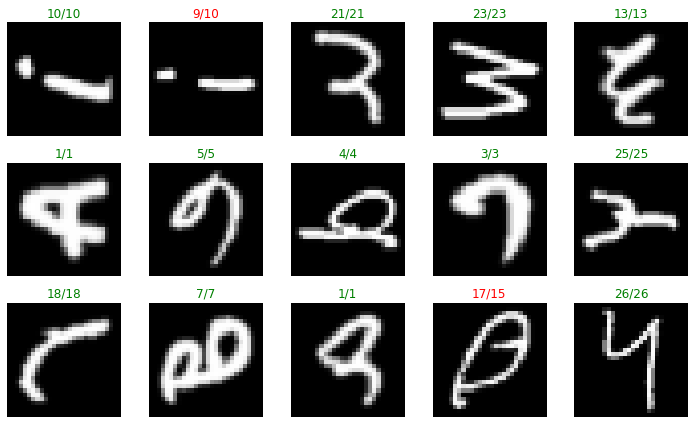

In [10]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['test'])-1)
        img, label = dataset['test'][ix]
        preds = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(preds, axis=1)[0].item()
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.axis("off")
        plt.title(f'{label}/{pred}', color = "red" if label != pred else "green")
plt.tight_layout()
plt.show()